# Import Libraries

In [1]:
import os
import random
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



# Set Device

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Set Dataset Paths

In [4]:
# ==========================
# 3. Paths
# ==========================
train_dir = "/kaggle/input/plants-dataset/CropsData/train"
test_dir  = "/kaggle/input/plants-dataset/CropsData/test"

# Define Image Transformations

In [11]:
from torchvision import transforms

# ==========================
# 4. Transforms
# ==========================
transform = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),        # resize all images
        transforms.RandomHorizontalFlip(),    # simple augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]) # ImageNet normalization
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


# Load Dataset

In [16]:
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights


# ==========================
# 5. Datasets & Loaders
# ==========================
train_dataset = datasets.ImageFolder(train_dir, transform=transform["train"])
test_dataset  = datasets.ImageFolder(test_dir, transform=transform["test"])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)
print("Number of classes:", num_classes)

# ==========================
# 6. Model: MobileNetV2
# ==========================
import torch.nn as nn
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# Load pretrained MobileNetV2
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)


# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Classes: ['American Bollworm on Cotton', 'Anthracnose on Cotton', 'Army worm', 'Becterial Blight in Rice', 'Brownspot', 'Common_Rust', 'Cotton Aphid', 'Flag Smut', 'Gray_Leaf_Spot', 'Healthy Maize', 'Healthy Wheat', 'Healthy cotton', 'Leaf Curl', 'Leaf smut', 'Mosaic sugarcane', 'RedRot sugarcane', 'RedRust sugarcane', 'Rice Blast', 'Sugarcane Healthy', 'Tungro', 'Wheat Brown leaf Rust', 'Wheat Stem fly', 'Wheat aphid', 'Wheat black rust', 'Wheat leaf blight', 'Wheat mite', 'Wheat powdery mildew', 'Wheat scab', 'Wheat___Yellow_Rust', 'Wilt', 'Yellow Rust Sugarcane', 'bacterial_blight in Cotton', 'bollworm on Cotton', 'cotton mealy bug', 'cotton whitefly', 'maize ear rot', 'maize fall armyworm', 'maize stem borer', 'pink bollworm in cotton', 'red cotton bug', 'thirps on  cotton']
Number of classes: 41


100%|██████████| 13.6M/13.6M [00:00<00:00, 123MB/s]


# Apply Random Undersampling

In [17]:
targets = [label for _, label in train_dataset.samples]
class_counts = Counter(targets)
min_count = min(class_counts.values())
print("Original class distribution:", class_counts)

undersampled_samples = []
for class_idx, count in class_counts.items():
    class_samples = [(path, label) for path, label in train_dataset.samples if label == class_idx]
    if count > min_count:
        sampled = random.sample(class_samples, min_count)  # Reduce to minority size
    else:
        sampled = class_samples
    undersampled_samples.extend(sampled)

train_dataset.samples = undersampled_samples
print("New class distribution after undersampling:", Counter([label for _, label in train_dataset.samples]))

Original class distribution: Counter({0: 375, 1: 375, 2: 375, 3: 375, 4: 375, 5: 375, 6: 375, 7: 375, 8: 375, 9: 375, 10: 375, 11: 375, 13: 375, 14: 375, 15: 375, 16: 375, 17: 375, 18: 375, 19: 375, 20: 375, 21: 375, 22: 375, 23: 375, 24: 375, 25: 375, 26: 375, 27: 375, 28: 375, 29: 375, 30: 375, 31: 375, 32: 375, 33: 375, 34: 375, 35: 375, 37: 375, 38: 375, 39: 375, 40: 375, 12: 374, 36: 370})
New class distribution after undersampling: Counter({0: 370, 1: 370, 2: 370, 3: 370, 4: 370, 5: 370, 6: 370, 7: 370, 8: 370, 9: 370, 10: 370, 11: 370, 12: 370, 13: 370, 14: 370, 15: 370, 16: 370, 17: 370, 18: 370, 19: 370, 20: 370, 21: 370, 22: 370, 23: 370, 24: 370, 25: 370, 26: 370, 27: 370, 28: 370, 29: 370, 30: 370, 31: 370, 32: 370, 33: 370, 34: 370, 35: 370, 36: 370, 37: 370, 38: 370, 39: 370, 40: 370})


# Create DataLoaders

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load MobileNetV2

# Define Loss Function and Optimizer

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train the Model

In [24]:
from tqdm import tqdm

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Wrap train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]", leave=True)

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar dynamically
        pbar.set_postfix({
            "Loss": f"{running_loss/len(train_loader):.4f}",
            "Acc": f"{100*correct/total:.2f}%"
        })

    # Final summary per epoch
    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {running_loss/len(train_loader):.4f} | Accuracy: {acc:.2f}%")


Epoch [1/5]: 100%|██████████| 475/475 [02:35<00:00,  3.05it/s, Loss=0.6108, Acc=81.42%]


Epoch [1/5] | Loss: 0.6108 | Accuracy: 81.42%


Epoch [2/5]: 100%|██████████| 475/475 [02:30<00:00,  3.16it/s, Loss=0.4912, Acc=84.67%]


Epoch [2/5] | Loss: 0.4912 | Accuracy: 84.67%


Epoch [3/5]: 100%|██████████| 475/475 [02:30<00:00,  3.15it/s, Loss=0.4199, Acc=86.94%]


Epoch [3/5] | Loss: 0.4199 | Accuracy: 86.94%


Epoch [4/5]: 100%|██████████| 475/475 [02:31<00:00,  3.13it/s, Loss=0.3712, Acc=88.48%]


Epoch [4/5] | Loss: 0.3712 | Accuracy: 88.48%


Epoch [5/5]: 100%|██████████| 475/475 [02:29<00:00,  3.19it/s, Loss=0.3399, Acc=89.06%]

Epoch [5/5] | Loss: 0.3399 | Accuracy: 89.06%


# Evaluate the Model

In [25]:
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("\n--- Test Results ---")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))





--- Test Results ---
Accuracy : 0.8875878220140515
Precision: 0.8982122225268309
Recall   : 0.88758615263572
F1-score : 0.8878976980322106

Classification Report:
                              precision    recall  f1-score   support

American Bollworm on Cotton       0.49      0.76      0.60       125
      Anthracnose on Cotton       0.95      0.98      0.96       125
                  Army worm       0.97      0.90      0.93       125
   Becterial Blight in Rice       0.94      0.90      0.92       125
                  Brownspot       0.93      0.98      0.95       125
                Common_Rust       0.96      0.96      0.96       125
               Cotton Aphid       0.86      0.90      0.88       125
                  Flag Smut       0.98      0.86      0.91       125
             Gray_Leaf_Spot       0.97      0.95      0.96       125
              Healthy Maize       1.00      0.90      0.95       125
              Healthy Wheat       0.95      0.82      0.88       125
      

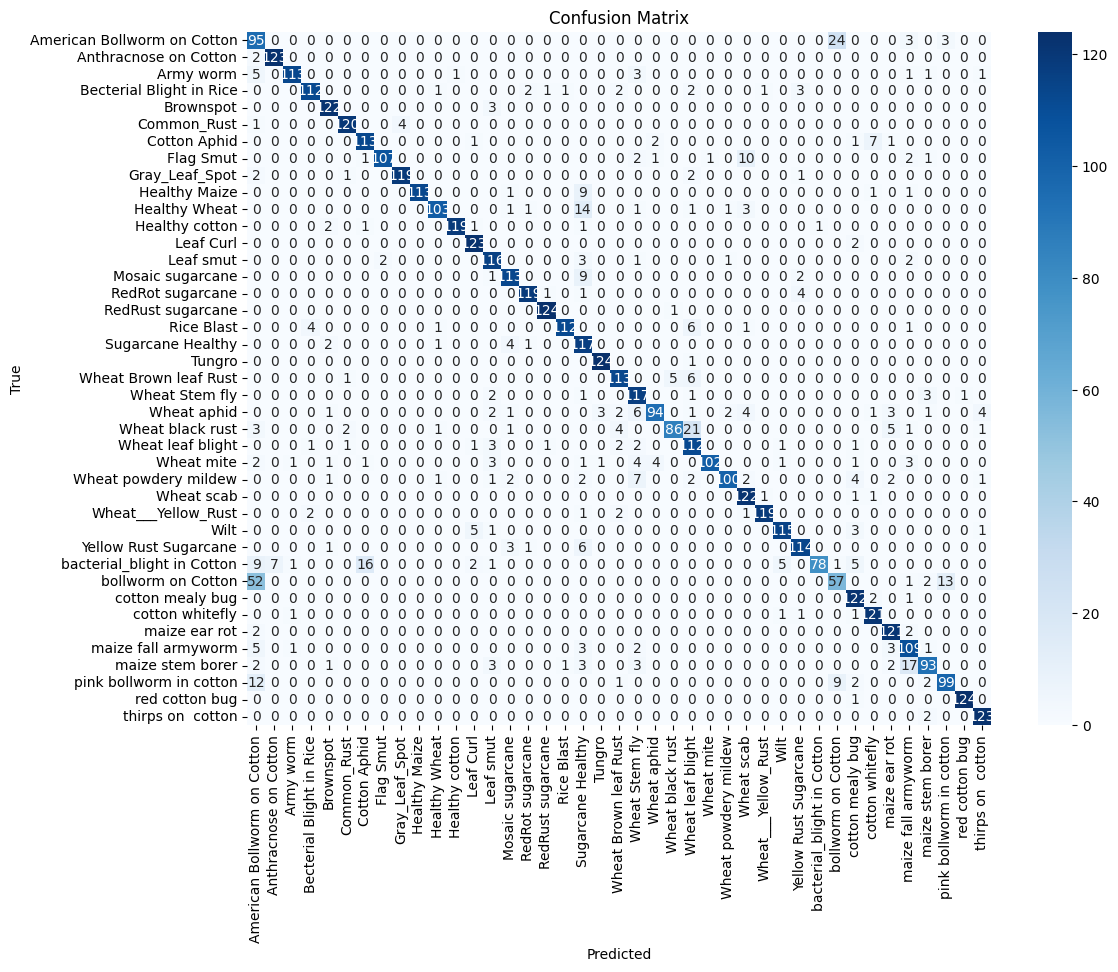

In [27]:
#=====================
#Confusion matrix
#===================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,9))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()